# Image Paraphrasing

In [1]:
import os
os.environ["CUDA_VISIBLE_DEVICES"] = '2'
import tensorflow as tf
import numpy as np
from time import time
import matplotlib.pyplot as plt
% matplotlib inline
import cv2
from scipy.misc import imsave
# from utils import receptive_field_computer
from utils import *
import itertools
from neural_style import build_model
# from models_bedroom import *
from nets import *
from scipy.misc import imsave

nsample = 64
ntimes = 4
nimages = 3

# Hyperparameter for Part Change
SHOW_IMAGE = False
npx_list = [64]
# lr_list = [8e-3 * 2**i for i in range(-6,7)]
lr_list = [9e-2] # For adam
# lr_list = [1e3] # For sgd [1e3] or [1e2]
max_step_list = [1000]
main_coef_list = [1.]
mask_pos_list = [None]
mask_prob_list = [0.5]
b1 = 0.4
b2 = 0.99
# b1=0.2
# b2=0.5


# Discriminator 
alpha_list = [0.]

# Pixel Space
gamma_list = [0.]#[0.1/255.]

noise_coef_list =  [0.0005]#[0.0005]
# a = 2e-7
# b = 1.5e-7
# n = 5
# noise_coef_list =  list(np.arange(b,a,(a-b)/n))



# content_layers_list = [['relu%d_%d'%(1,1), 'relu%d_%d'%(2,1), 'relu%d_%d'%(3,1), 'relu%d_%d'%(4,1),'relu%d_%d'%(5,1)]]
# content_weights_list = [[0, 2, 3, 10, 0.]]
# content_types_list = [['Feature','Feature','Feature','Feature','Feature']]
# mask_types_list = [['main', 'main', 'main', 'main', 'main']]

# content_layers_list = [['relu%d_%d'%(3,1), 'relu%d_%d'%(4,1)]]
# content_weights_list = [[7, 10]]
# content_types_list = [['Feature','Feature']]
# mask_types_list = [[ 'main', 'main']]

content_layers_list = [['relu%d_%d'%(1,1)],['relu%d_%d'%(2,1)],['relu%d_%d'%(3,1)],['relu%d_%d'%(4,1)],['relu%d_%d'%(5,1)],['relu%d_%d'%(5,2)],['relu%d_%d'%(5,3)],['pool%d'%5]]
content_weights_list = [[1]]
content_types_list = [['Feature']]
mask_types_list = [[ 'main']] # For pixel space, main or comp(lementary)
latent_mask = rectangle(np.zeros((8,8)), (4,4), (3,3)).reshape((1,8,8,1)).astype(np.float32)
latent_masks_list = [[None]]#[[latent_mask], [1-latent_mask]]


Dataset = 'Bedroom'
result_path = 'Results_%s_semantic_layer_new_noise'%Dataset

# n_list = [str(i) for i in np.random.randint(10000, size=1)]
# n_list = ['0001256'] #Red bed

# content_img_paths = ['../BEGAN-tensorflow/data/Bedroom/splits/train/%s.jpg'%n.zfill(7) for n in n_list]
if Dataset == 'Bedroom':
#     n_list = ['4596']
#     content_img_paths = ['/home/tim/kjliu/project-file/data/Bedroom/splits/train/0004596.jpg']
#     n_list = [str(i) for i in np.random.randint(50000, size=nimages)]
    filelist = listfile('/home/tim/kjliu/project-file/data/Bedroom/splits/test/')
    content_img_paths = [filelist[i] for i in np.random.randint(low = 0, high = len(filelist), size=nimages)]
elif Dataset == 'CelebA':
#     n_list = [str(i) for i in np.random.randint(19962, size=nimages)]

#     n_list = ['870'] #['23245]
#     content_img_paths = ['/home/tim/kjliu/project-file/data/CelebA/splits/train/%s.jpg'%n.zfill(6) for n in n_list]
    
    filelist = listfile('/home/tim/kjliu/project-file/data/CelebA/splits/test/')
    content_img_paths = [filelist[i] for i in np.random.randint(low = 0, high = len(filelist), size=nimages)]

hyper_lists=[npx_list
           ,lr_list
           ,max_step_list
           ,main_coef_list
           ,mask_pos_list
           ,alpha_list
           ,gamma_list
           ,noise_coef_list
           ,content_layers_list
           ,content_weights_list
           ,content_types_list
           ,mask_prob_list
           ,mask_types_list
           ,content_img_paths
           ,latent_masks_list
            ]



3 3
4 4


3 3
4 4


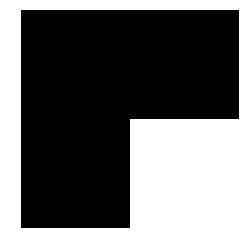

In [2]:
test_img = rectangle(np.zeros((8,8)), (4,4), (3,3))
plot_img(test_img, gray=True)

In [3]:
def assign_hyperparameter(hyperparameters, root_path):
    global npx, lr, max_step, main_coef, mask_pos, mask, prob, gram_mask
    global alpha, recon_mask
    global gamma, pixel_mask
    global noise_coef
    global content_layers, content_weights, content_types
    global mask_types
    global b1, b2
    global content_img_path
    # Hyperparameter for Part Change
    npx = hyperparameters[0]
    lr = hyperparameters[1]
    max_step = hyperparameters[2]
    main_coef = hyperparameters[3]
    mask_pos = hyperparameters[4]
    
    


    noise_coef =  lr * hyperparameters[7]
    content_layers = hyperparameters[8]
    content_weights = hyperparameters[9] / np.sum(hyperparameters[9])
    content_types = hyperparameters[10]
    prob = hyperparameters[11]
    
    mask = 1#-gen_mask(npx, (32,29), blur = 1, prob = 1., rect_size = (30,30)).reshape(npx,npx,1)
    #mask = gen_mask(npx, mask_pos, blur = 10, prob = prob).reshape(npx,npx,1)
    
    # Discriminator 
    alpha = hyperparameters[5]      
    recon_mask = 1 if mask_pos is None else (1-mask)

    # Pixel Space
    gamma = hyperparameters[6]
    pixel_mask = 1 - mask
    
    mask_types = hyperparameters[12]
    content_img_path = hyperparameters[13]
    global latent_masks
    latent_masks = hyperparameters[14]
    with open(os.path.join(root_path, 'hyperparameters.txt'), 'a') as f:
        f.write('\n\n\n')
        f.write('')
        f.write('npx: %d\n'%npx)
        f.write('lr: %.3E\n'%lr)
        f.write('max_step: %d\n'%max_step)
        f.write('main_coef: %.3E\n'%main_coef)
        f.write('mask_pos: %s\n'%(mask_pos, ))
        f.write('alpha: %.3E\n'%alpha)
        f.write('gamma: %.3E\n'%gamma)
        f.write('noise_coef: %.3E\n'%noise_coef)
        f.write('content_layers: %s\n'%content_layers)
        f.write('content_weights: %s\n'%content_weights)
        f.write('content_types: %s\n'%content_types)
        f.write('mask_prob: %s\n'%prob)
        f.write('beta1: %s\n'%b1)
        f.write('beta2: %s\n'%b2)

## Check reference image

(64, 64, 3)


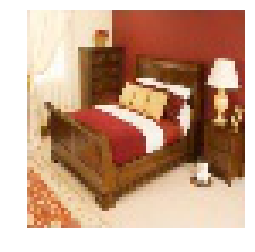

In [4]:
img = read_img(content_img_paths[0])
print(img.shape)
plot_img(img/255.)

## Load corresponding model architecture
- WGAN for Bedroom
- BEGAN for CelebA

In [5]:

if Dataset == 'Bedroom':
    from gan_64x64 import GeneratorAndDiscriminator
    import tflib as lib
elif Dataset == 'CelebA':
    #Img range [-1, 1]
    from models_celeba_began import *
# lib.delete_all_params()
# print(lib._params, lib._param_aliases)

/home/tim/anaconda3/lib/python3.5/site-packages/matplotlib/__init__.py:1405: UserWarning: 
This call to matplotlib.use() has no effect because the backend has already
been chosen; matplotlib.use() must be called *before* pylab, matplotlib.pyplot,
or matplotlib.backends is imported for the first time.

  warnings.warn(_use_error_msg)


In [ ]:
# n = [op.name for op in tf.get_default_graph().get_operations() ]
# print(n)

## Optimization main part

In [ ]:


for idx, hyperparameters in enumerate(itertools.product(*hyper_lists)):
#     for i in range(100):
    print('Hyperparameters: %s'%(hyperparameters,))
    ########################### Prepare Experiment ###########################
    root_path = os.path.join(result_path, Dataset + '_' + get_time())
    mkdir(root_path)
    assign_hyperparameter(hyperparameters, root_path)

    ########################### Load Content Image ###########################
#     if len(content_img_paths) > 1:
#         content_img = read_imgs(content_img_paths, npx) 
#     else:
#         content_img = read_img(content_img_paths[0], npx)
    content_img = read_img(content_img_path, npx)
    content_img_orig = content_img.copy()
    #content_img = content_img.reshape(-1,npx,npx,3)
    content_img = preprocess(content_img, npx = npx)

#     if len(content_img_paths) > 1:
#         content_img_orig_grid = color_grid_vis(content_img_orig)
#         plot_img(content_img_orig_grid/255.
#                  ,title='Content Img'
#                  ,save_path=os.path.join(root_path, 'content_img_original.jpg')
#                  ,show = SHOW_IMAGE
#                 )
#     else:
    content_img_orig_grid = content_img_orig
    plot_img(content_img_orig/255.
             ,title='Content Img'
             ,save_path=os.path.join(root_path, 'content_img_original.jpg')
             ,show = SHOW_IMAGE
             )

    plot_img(content_img_orig * mask / 255.
             ,title='Masked Content Img'
             ,save_path=os.path.join(root_path, 'masked_ContImg.jpg')
             ,show = SHOW_IMAGE
            )
    
    

    ########################### Build Graph ###########################
    if Dataset == 'Bedroom':
        with tf.variable_scope('Paraphrasing') as scope:
        #     scope.reuse_variables()
           paint_board = tf.get_variable('Paint_board', [nsample, 128],initializer=tf.random_normal_initializer())
        init_op_paint_board = tf.variables_initializer([paint_board])
        generator, discriminator = GeneratorAndDiscriminator()
        init_img_orig = generator(nsample, noise=paint_board)
        init_img = tf.transpose(tf.reshape(init_img_orig, [-1,3, 64,64]), [0,2,3,1])
        init_img = tf.image.resize_nearest_neighbor(init_img, [npx, npx])
        init_img = (init_img + 1)/2 * 255.
        init_img_vgg = init_img
        init_img_vgg = vgg_img(init_img)

        init_img_logits = discriminator(init_img_orig) # Bug Need denorm??
        g_vars = tf.contrib.framework.get_variables('Generator')
        d_vars = tf.contrib.framework.get_variables('Discriminator')
        var = g_vars + d_vars
        net = build_model(content_img, mask = tf.constant(mask, dtype=tf.float32))
    #     net = build_model(vgg_img(content_img), mask = tf.constant(mask, dtype=tf.float32))
        net2 = build_model(init_img_vgg, is_gen=True, mask = tf.constant(mask, dtype=tf.float32))
        net3 = build_model(content_img, mask = tf.constant(pixel_mask, dtype=tf.float32))
        net4 = build_model(init_img_vgg, is_gen=True, mask = tf.constant(pixel_mask, dtype=tf.float32))
    elif Dataset == 'CelebA':
        with tf.variable_scope('Paraphrasing') as scope:
            paint_board = tf.get_variable('Paint_board', [nsample, 64],initializer=tf.random_uniform_initializer())
        init_op_paint_board = tf.variables_initializer([paint_board])

        init_img_orig, g_vars = GeneratorCNN(paint_board,128,3,4,'NCHW',reuse=False)
        init_img = tf.transpose(init_img_orig, [0,2,3,1])
        init_img = tf.image.resize_nearest_neighbor(init_img, [npx, npx])
        init_img = (init_img + 1)/2 * 255.
        init_img_vgg = vgg_img(init_img)

        init_img_recon,_, d_vars = DiscriminatorCNN(init_img_orig,3,64,4,128,'NCHW') # BUG_need denorm

        var = g_vars + d_vars

        net = build_model(content_img, mask = tf.constant(mask, dtype=tf.float32))
        net2 = build_model(init_img_vgg, is_gen=True, mask = tf.constant(mask, dtype=tf.float32))
        net3 = build_model(content_img, mask = tf.constant(pixel_mask, dtype=tf.float32))
        net4 = build_model(init_img_vgg, is_gen=True, mask = tf.constant(pixel_mask, dtype=tf.float32))
    ########################### Loss ###########################
    from time import time
    t = time()
    sess = tf.Session()
    saver = tf.train.Saver(var)
    
    
    if Dataset == 'CelebA':
        saver.restore(sess, tf.train.latest_checkpoint('logs/CelebA_0517_071609/'))
    #elif Dataset == 'Bedroom': # Wrong model(with Batchnorm)
    #    saver.restore(sess, tf.train.latest_checkpoint('logs/Bedroom_0726_161928/'))
    elif Dataset == 'Bedroom':
        saver.restore(sess, tf.train.latest_checkpoint('logs/Bedroom_0812_011108/'))
    print("Cost time: %.2fs"%(time() - t))

    # content loss
    L_content, loss_collections = sum_content_losses(sess, net, net2, net3, net4,
                                                     content_img,
                                                     content_layers=content_layers,
                                                     content_layer_weights=content_weights,
                                                     content_types = content_types,
                                                     mask_types = mask_types,
                                                     latent_mask = latent_masks
                                                    )

    # Discrim loss
    if Dataset == 'CelebA':
        discrim_loss = tf.reduce_mean(tf.abs(init_img_recon - init_img_orig) )
    elif Dataset == 'Bedroom':
        discrim_loss = - tf.reduce_mean(init_img_logits)

    # total loss
    L_total  = main_coef * L_content
    alpha_var = tf.get_variable(name='alpha', dtype=tf.float32, initializer=alpha * 1.0)
    L_total += alpha_var*discrim_loss
    L_total += gamma*tf.reduce_mean(tf.abs(content_img_orig - init_img)*tf.constant((pixel_mask),dtype=tf.float32))
    
    ############################ optimization algorithm ###############################
    init_z = paint_board



    with tf.variable_scope('adam_optimizer') as vs:
        optimizer = tf.train.AdamOptimizer(lr, beta1=b1, beta2=b2)
#         optimizer = tf.train.GradientDescentOptimizer(lr)
#         optimizer = tf.train.RMSPropOptimizer(lr)

        gvs = optimizer.compute_gradients(L_total, var_list=[init_z])
        gvs = [(grad+noise_coef*tf.random_normal(tf.shape(grad)), var) for grad, var in gvs]

        train_op = optimizer.apply_gradients(gvs)
        vars = tf.contrib.framework.get_variables(vs)
    init_op = tf.initialize_variables(vars + [alpha_var])    

    ########################### Session Run ##########################
    output_data = []
#     plot_img(content_img_orig/255.
#                 ,save_path=os.path.join(root_path,'content.png')
#                 ,show=SHOW_IMAGE
#              )
    for t in range(ntimes):
        sess.run(init_op_paint_board)
        sess.run(init_op)
        i = sess.run(init_img)
        grid_imgs = color_grid_vis(i)
        rand = str(np.random.randint(10000))
        plot_img(my_post(grid_imgs)
                 ,title='Sample Img Init'
                 ,save_path=os.path.join(root_path, 'samples_init.jpg')
                 ,show=SHOW_IMAGE
                )
        train_loss = []
        for iterations in trange(max_step):
            sess.run(train_op)
            if iterations % 100 == 0:
                curr_loss = sess.run(L_total)
                train_loss.append(curr_loss)
                img = sess.run(init_img)
                grid_imgs = color_grid_vis(img)

                print("At iterate {}\tf=  {:.4f}".format(iterations, curr_loss))
    #             loss = sess.run(loss_collections)
    #             print(loss)
                plot_img(my_post(grid_imgs)
                         ,title='Sample Img Iter_%d'%iterations
                         ,save_path=os.path.join(root_path, 'samples_iter_%d.png'%iterations)
                         ,show=SHOW_IMAGE
                        )
            if iterations > 99:
                if iterations % 100 == 0:
                    alpha_var.assign(sess.run(alpha_var) * 1)
        img = sess.run(init_img)
        output_data.append(img)

        grid_imgs = color_grid_vis(img)

        print("At iterate {}\tf=  {:.4f}".format(iterations, curr_loss))
        plot_img(my_post(grid_imgs)
                 ,title='Sample Img Iter_%d'%iterations
                 ,save_path=os.path.join(root_path, 'samples_iter_%d.png'%iterations)
                 ,show=SHOW_IMAGE
                )

        ########################### Plot final learning result & write to file #####################
        plt.figure()
        plt.plot(np.arange(len(train_loss)) * 100, train_loss, color='blue', label='Train loss')
        plt.legend(loc="upper right")
        plt.xlabel('#Iteration')
        plt.ylabel('Loss')
        plt.show()
        print('Final loss: %.4f'%train_loss[-1])
        with open(os.path.join(root_path, 'hyperparameters.txt'), 'a') as f:
            f.write('Final loss: %d\n'%train_loss[-1])
    output_data = np.concatenate(output_data)
    for idx, pic in enumerate(output_data):
        imsave(os.path.join(root_path, '%s.png'%str(idx).zfill(5)),my_post(pic) )
    plot_result(content_img_orig, output_data, save_path = os.path.join(root_path,'results.png'))
    ########################### Close Session & Reset Graph
    tf.reset_default_graph()
    #sess.close()
    if Dataset == 'Bedroom':
        lib.delete_all_params()


Hyperparameters: (64, 0.09, 1000, 1.0, None, 0.0, 0.0, 0.0005, ['relu1_1'], [1], ['Feature'], 0.5, ['main'], '/home/tim/kjliu/project-file/data/Bedroom/splits/test/1262592.jpg', [None])
INFO:tensorflow:Restoring parameters from logs/Bedroom_0812_011108/model.ckpt-137399
Cost time: 1.29s
['relu1_1'] [ 1.] ['Feature'] ['main']
Layer: relu1_1, Feature, 1, main
Latent shape: (1, 64, 64, 64)
Instructions for updating:
Use `tf.variables_initializer` instead.


  0%|          | 1/1000 [00:02<46:33,  2.80s/it]

At iterate 0	f=  0.0026


 10%|█         | 101/1000 [00:43<07:26,  2.01it/s]

At iterate 100	f=  0.0025


 19%|█▉        | 193/1000 [01:19<05:23,  2.49it/s]

In [ ]:
mask

In [ ]:

#     plot_img(my_post(img)
#              ,save_path=os.path.join(root_path, '%s.jpg'%str(idx).zfill(5))
#              ,show=SHOW_IMAGE
#             )

## Evaluation 

In [ ]:
print(img.shape)

In [ ]:
SHOW_IMAGE = False

In [ ]:
# !python msssim_Copy1.py --original_image=187628.jpg --compared_image=187627.jpg

In [ ]:
# !python msssim.py --path=./ --nsamples=1
